In [48]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from datasets import load_dataset
from collections import Counter

from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.calibration import CalibratedClassifierCV

np.random.seed(42)
random.seed(42)

In [2]:
# QUESTION 7: Dimensionality Reduction

DATA_PATH = "Project1-ClassificationDataset.csv"
df = pd.read_csv(DATA_PATH)

df = df[["full_text", "root_label", "leaf_label"]].copy()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

train_texts = train_df["full_text"].astype(str).tolist()
test_texts  = test_df["full_text"].astype(str).tolist()

Train size: (2780, 3)
Test size: (696, 3)


In [3]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_df["root_label"])
y_test  = label_encoder.transform(test_df["root_label"])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Label mapping: {'climate': np.int64(0), 'sports': np.int64(1)}


In [4]:
# similar to Q3
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"", texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u ', " you ", texter)
    texter = re.sub('`', "", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ', texter)
    cleaner = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(cleaner, '', texter)
    if texter == "":
        texter = ""
    return texter

train_texts_clean = [clean(t) for t in train_texts]
test_texts_clean  = [clean(t) for t in test_texts]

import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

required_packages = [
    "punkt",
    "punkt_tab",
    "averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng",
    "wordnet",
    "omw-1.4"
]

for pkg in required_packages:
    try:
        nltk.data.find(pkg)
    except LookupError:
        nltk.download(pkg, quiet=True)

lemmatizer = WordNetLemmatizer()

def _to_wordnet_pos(treebank_tag: str):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

_num_like = re.compile(r"^[+-]?(\d+(\.\d*)?|\.\d+)$")

def lemma_tokenizer(text: str):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)

    lemmas = []
    for w, tag in tagged:
        if _num_like.match(w):
            continue

        if not any(ch.isalpha() for ch in w):
            continue

        wn_pos = _to_wordnet_pos(tag)
        lemmas.append(lemmatizer.lemmatize(w, pos=wn_pos))
    return lemmas

count_vec = CountVectorizer(
    stop_words="english",
    tokenizer=lemma_tokenizer,
    token_pattern=None,
    min_df=3
)

X_train_counts = count_vec.fit_transform(train_texts_clean)
X_test_counts  = count_vec.transform(test_texts_clean)

tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)
X_test_tfidf  = tfidf.transform(X_test_counts)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

c:\Users\Joel\ECE 219 Project 1\.venv\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  warnings.warn(


TF-IDF train shape: (2780, 14250)
TF-IDF test shape: (696, 14250)


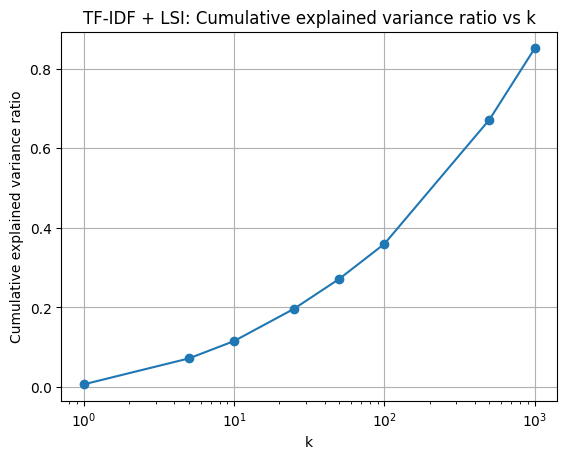

LSI k=25 train shape: (2780, 25)
LSI k=25 test shape: (696, 25)


In [5]:
# 7. a)

k_values = [1, 5, 10, 25, 50, 100, 500, 1000]
max_k = X_train_tfidf.shape[1] - 1

explained_variance_ratio = []
valid_k = []

for k in k_values:
    if k > max_k:
        continue

    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(X_train_tfidf)

    explained_variance_ratio.append(svd.explained_variance_ratio_.sum())
    valid_k.append(k)

plt.figure()
plt.plot(valid_k, explained_variance_ratio, marker="o")
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("Cumulative explained variance ratio")
plt.title("TF-IDF + LSI: Cumulative explained variance ratio vs k")
plt.grid(True)
plt.show()

k = 25

svd_25 = TruncatedSVD(n_components=k, random_state=42)
X_train_lsi_25 = svd_25.fit_transform(X_train_tfidf)
X_test_lsi_25  = svd_25.transform(X_test_tfidf)

print(f"LSI k={k} train shape:", X_train_lsi_25.shape)
print(f"LSI k={k} test shape:", X_test_lsi_25.shape)

In [6]:
# 7. b)

def get_reconstruction_mse(X, X_hat):
    n, m = X.shape
    X_frob_sq = float(np.sum(X.data ** 2))
    Xhat_frob_sq = float(np.sum(X_hat ** 2))
    X_coo = X.tocoo()
    inner_prod = float(np.sum(X_coo.data * X_hat[X_coo.row, X_coo.col]))
    frob_diff_sq = X_frob_sq + Xhat_frob_sq - 2.0 * inner_prod
    return frob_diff_sq / (n * m)

X_train_lsi_hat = X_train_lsi_25 @ svd_25.components_
X_test_lsi_hat  = X_test_lsi_25  @ svd_25.components_

mse_lsi_train = get_reconstruction_mse(X_train_tfidf, X_train_lsi_hat)
mse_lsi_test  = get_reconstruction_mse(X_test_tfidf,  X_test_lsi_hat)

print("k = 25\n")
print("LSI reconstruction MSE:")
print("train:", mse_lsi_train)
print("test:", mse_lsi_test, '\n')

nmf_25 = NMF(n_components=25, init="nndsvda", random_state=42, max_iter=400)

W_train = nmf_25.fit_transform(X_train_tfidf)
W_test  = nmf_25.transform(X_test_tfidf)
H = nmf_25.components_

print("NMF train shape:", W_train.shape)
print("NMF test shape:", W_test.shape)

X_train_nmf_hat = W_train @ H
X_test_nmf_hat  = W_test  @ H

mse_nmf_train = get_reconstruction_mse(X_train_tfidf, X_train_nmf_hat)
mse_nmf_test  = get_reconstruction_mse(X_test_tfidf,  X_test_nmf_hat)

print("NMF reconstruction MSE:")
print("  train:", mse_nmf_train)
print("  test :", mse_nmf_test)

if mse_lsi_train < mse_nmf_train:
    smaller = "LSI"
else:
    smaller = "NMF"

print("\nSmaller reconstruction error:", smaller)
print("LSI/TruncatedSVD does not have a nonnegativity constraint. NMF is constrained to nonnegative factors, so it usually cannot match the optimal SVD reconstruction error.")


k = 25

LSI reconstruction MSE:
train: 5.4628105866023575e-05
test: 5.613464262285954e-05 

NMF train shape: (2780, 25)
NMF test shape: (696, 25)
NMF reconstruction MSE:
  train: 5.502233200703562e-05
  test : 5.635256116921431e-05

Smaller reconstruction error: LSI
LSI/TruncatedSVD does not have a nonnegativity constraint. NMF is constrained to nonnegative factors, so it usually cannot match the optimal SVD reconstruction error.


In [7]:
# 7. c) optional
# based on either GLoVE or LLM embeddings

SVM γ=2000
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914

SVM γ=0.0005
Confusion Matrix:
[[299  29]
 [ 18 350]]
Accuracy: 0.9324712643678161
Recall: 0.9510869565217391
Precision: 0.9234828496042217
F1-score: 0.9370816599732262

SVM γ=100000
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914



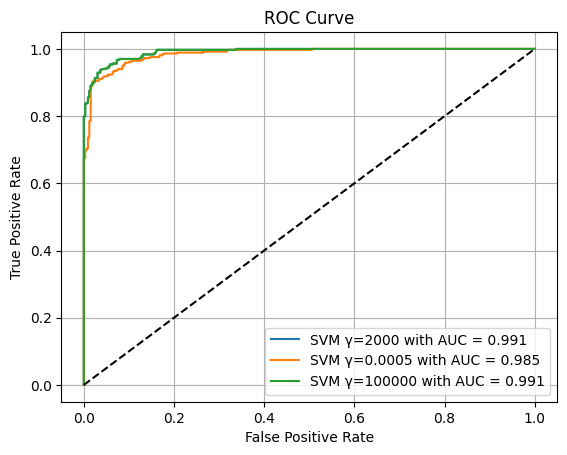

In [8]:
# 8. a)

def analyze_svm(model, test_features, test_labels, model_name=""):
    predicted_labels = model.predict(test_features)
    predicted_probabilities = model.predict_proba(test_features)[:, 1]

    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    accuracy = accuracy_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    f1_score_ = f1_score(test_labels, predicted_labels)

    false_positive_rate, true_positive_rate, _ = roc_curve(test_labels, predicted_probabilities)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    print(model_name)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1_score_}\n")

    plt.plot(
        false_positive_rate,
        true_positive_rate,
        label=f"{model_name} with AUC = {roc_auc:.3f}"
    )

plt.figure()
gammas = [2000, 0.0005, 100000]
for gamma in gammas:
    base_svm = LinearSVC(C=gamma, dual=False, max_iter=5000)
    svm = CalibratedClassifierCV(base_svm)
    svm.fit(X_train_lsi_25, y_train)
    analyze_svm(svm, X_test_lsi_25, y_test, model_name=f"SVM γ={gamma}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()



Which SVM performs better?

    The SVM with γ = 2000 (hard margin) performs better.
    It achieves higher accuracy and F1-score than the soft-margin SVM. The confusion matrix is also more balanced with fewer misclassifications.

What about γ = 100000?

    The SVM with γ = 100000 performs identically to γ = 2000.
    This means the classifier has already reached a stable maximum-margin solution, so increasing γ affect performance.

What happens for the soft margin SVM? Why?

    The soft margin SVM does not perform as well because it under-regularizes the margin constraint.

    The confusion matrix has more false positives (29 vs. 19), which lowers the overall accuracy and precision. Since the classifier is too lenient, we get more points that cross the margin and we get more classification errors.

Does the ROC curve reflect the performance of the soft-margin SVM? Why?

    Not completely. ROC curve evaluates ranking across thresholds, but the confusion matrix shows worse performance at a
     decision threshold.

In [9]:
# 8. b)

gammas = [10**k for k in range(-3, 7)]
avg_cv_accuracy = []

for gamma in gammas:
    svm = LinearSVC(C=gamma, dual=False, max_iter=5000)
    scores = cross_val_score(svm, X_train_lsi_25, y_train, cv=5, scoring="accuracy")
    avg_cv_accuracy.append(scores.mean())

best_gamma = gammas[int(np.argmax(avg_cv_accuracy))]

print("Gammas:", gammas)
print("Avg CV accuracy:", [round(x, 4) for x in avg_cv_accuracy])
print("Best gamma:", best_gamma)

Gammas: [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
Avg CV accuracy: [np.float64(0.9342), np.float64(0.9338), np.float64(0.9388), np.float64(0.946), np.float64(0.9514), np.float64(0.9514), np.float64(0.9518), np.float64(0.9518), np.float64(0.9518), np.float64(0.9518)]
Best gamma: 1000


In [10]:
base_svm = LinearSVC(C=best_gamma, dual=False, max_iter=5000)
best_svm = CalibratedClassifierCV(base_svm)
best_svm.fit(X_train_lsi_25, y_train)

predicted_labels = best_svm.predict(X_test_lsi_25)
predicted_probs  = best_svm.predict_proba(X_test_lsi_25)[:, 1]

conf_matrix = confusion_matrix(y_test, predicted_labels)

accuracy = accuracy_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")

Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914


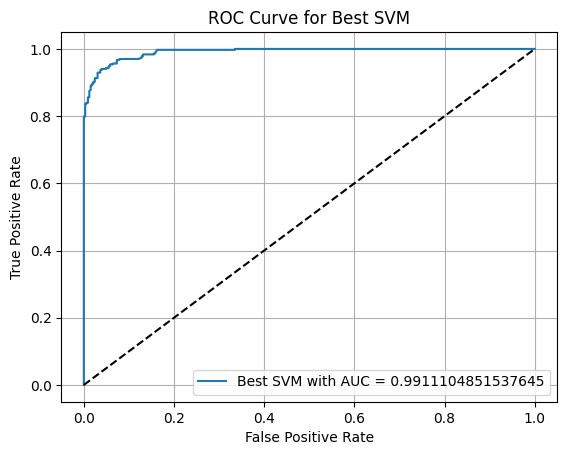

In [11]:
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, predicted_probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label=f"Best SVM with AUC = {roc_auc}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Best SVM")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 9. a)

def analyze_logistic_classifier(model, test_features, test_labels, model_name=""):
    predicted_labels = model.predict(test_features)
    predicted_probs = model.predict_proba(test_features)[:, 1]

    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    accuracy = accuracy_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)

    false_positive_rate, true_positive_rate, _ = roc_curve(test_labels, predicted_probs)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    print(model_name)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1}\n")

    plt.plot(false_positive_rate, true_positive_rate, label=f"{model_name} with AUC={roc_auc:.3f}")

LogReg (no regularization)
Confusion Matrix:
[[310  18]
 [ 18 350]]
Accuracy: 0.9482758620689655
Recall: 0.9510869565217391
Precision: 0.9510869565217391
F1-score: 0.9510869565217391



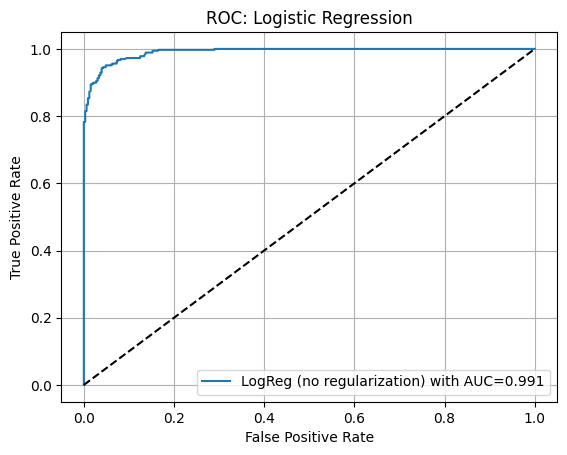

In [13]:
# Train a logistic classifier without regularization
no_regurlarization_logreg = LogisticRegression(penalty="l2", C=1e9, solver="lbfgs",max_iter=5000)
no_regurlarization_logreg.fit(X_train_lsi_25, y_train)

plt.figure()
analyze_logistic_classifier(no_regurlarization_logreg, X_test_lsi_25, y_test, "LogReg (no regularization)")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# 9. b) Find the optimal regularization coefficient

coefficients = [10**k for k in range(-5, 6)]

def find_optimal_regularization_coefficient(penalty_type):
    best_C = None
    best_cv_accuracy = -100.0

    for C in coefficients:
        if penalty_type == "l1":
            model = LogisticRegression(penalty="l1", C=C, solver="liblinear", max_iter=5000)
        else:
            model = LogisticRegression(penalty="l2", C=C, solver="lbfgs", max_iter=5000)

        scores = cross_val_score(model, X_train_lsi_25, y_train, cv=5, scoring="accuracy")
        avg_score = scores.mean()

        if avg_score > best_cv_accuracy:
            best_cv_accuracy = avg_score
            best_C = C

    return best_C, best_cv_accuracy

best_C_l1, best_acc_l1 = find_optimal_regularization_coefficient("l1")
best_C_l2, best_acc_l2 = find_optimal_regularization_coefficient("l2")

# 9. b) 1.
print("Optimal regularization coefficient for L1:", best_C_l1, "CV accuracy:", round(best_acc_l1, 4))
print("Optimal regularization coefficient for L2:", best_C_l2, "CV accuracy:", round(best_acc_l2, 4))

Optimal regularization coefficient for L1: 100 CV accuracy: 0.9514
Optimal regularization coefficient for L2: 100 CV accuracy: 0.9522


LogReg (no regularization)
Confusion Matrix:
[[310  18]
 [ 18 350]]
Accuracy: 0.9482758620689655
Recall: 0.9510869565217391
Precision: 0.9510869565217391
F1-score: 0.9510869565217391

LogReg L1, C=100
Confusion Matrix:
[[310  18]
 [ 18 350]]
Accuracy: 0.9482758620689655
Recall: 0.9510869565217391
Precision: 0.9510869565217391
F1-score: 0.9510869565217391

LogReg L2, C=100
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914



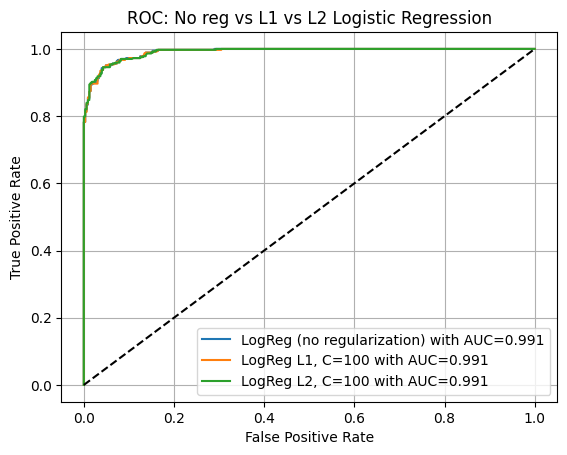

In [15]:
best_l1_logreg = LogisticRegression(penalty="l1", C=best_C_l1, solver="liblinear", max_iter=5000)
best_l2_logreg = LogisticRegression(penalty="l2", C=best_C_l2, solver="lbfgs", max_iter=5000)

best_l1_logreg.fit(X_train_lsi_25, y_train)
best_l2_logreg.fit(X_train_lsi_25, y_train)

plt.figure()
analyze_logistic_classifier(no_regurlarization_logreg,  X_test_lsi_25, y_test, "LogReg (no regularization)")
analyze_logistic_classifier(best_l1_logreg, X_test_lsi_25, y_test, f"LogReg L1, C={best_C_l1}")
analyze_logistic_classifier(best_l2_logreg, X_test_lsi_25, y_test, f"LogReg L2, C={best_C_l2}")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: No reg vs L1 vs L2 Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


9. b) 2.
Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classi-
fiers: w/o regularization, w/ L1 regularization and w/ L2 regularization

    All three models performed pretty much the same way. L2 performed slightly worse and the confusion matrices were slightly different.

9. b) 3. 

How does the regularization parameter affect the test error?

    No substantial affect since the classes are already split after TF-IDF + LSI

How are the learnt coefficients affected?

    L1 makes some of the coefficients zero while L2 shrinks them in a stable manner.

Why might one be interested in each type of regularization?

    L1 is good for selecting features, L2 for better stability and robustness, and no regularization when you want it faster when there is no
    need to avoid overfitting.

9. b) 4.

Both logistic regression and linear SVM are trying to classify data points using a linear
decision boundary.

What is the difference between their ways to find this boundary?

    Logistic regression finds the boundary by maximizing the conditional likelihood. SVM maximizes the margins between each class instead.

Why do their performances differ?

    Logistic regression fits over all points and SVM only fits on the boundary support vectors.

Is this difference statistically significant?

    Based on the findings above, the difference is not significant.

In [19]:
# 14.

map_row_to_class = {
    0:"basketball", 1:"baseball", 2:"tennis", 3:"football", 4:"soccer",
    5:"forest fire", 6:"flood", 7:"earthquake", 8:"drought", 9:"heatwave"
}
class_to_index = {name: idx for idx, name in map_row_to_class.items()}

y_train_leaf = train_df["leaf_label"].map(class_to_index).to_numpy()
y_test_leaf  = test_df["leaf_label"].map(class_to_index).to_numpy()

train_features = X_train_lsi_25
test_features  = X_test_lsi_25

In [35]:
def analyze_multiclass_models(model_name, true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(10)))
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average="macro", zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average="macro", zero_division=0)
    f1_score_value = f1_score(true_labels, predicted_labels, average="macro", zero_division=0)

    print(model_name)
    print("Accuracy:", accuracy)
    print("Macro Precision:", precision)
    print("Macro Recall:", recall)
    print("Macro F1:", f1_score_value)
    print("\nConfusion Matrix:")
    print(cm, '\n')
    return cm, accuracy, precision, recall, f1_score_value

In [36]:
# 14. b) 

nb_model = MultinomialNB()
if np.min(train_features) < 0:
    shift = -np.min(train_features)
    train_nb = train_features + shift
    test_nb = test_features + shift
else:
    train_nb = train_features
    test_nb = test_features
nb_model.fit(train_nb, y_train_leaf)
nb_pred = nb_model.predict(test_nb)
analyze_multiclass_models("MultinomialNB", y_test_leaf, nb_pred)

ovo_model = OneVsOneClassifier(LinearSVC(C=1.0, max_iter=5000))
ovo_model.fit(train_features, y_train_leaf)
ovo_pred = ovo_model.predict(test_features)
cm_ovo, acc_ovo, *_ = analyze_multiclass_models("SVM OvO", y_test_leaf, ovo_pred)

ovr_model = OneVsRestClassifier(LinearSVC(C=1.0, max_iter=5000))
ovr_model.fit(train_features, y_train_leaf)
ovr_pred = ovr_model.predict(test_features)
cm_ovr, acc_ovr, *_ = analyze_multiclass_models("SVM OvR", y_test_leaf, ovr_pred)

MultinomialNB
Accuracy: 0.5718390804597702
Macro Precision: 0.7676994485657599
Macro Recall: 0.5953901951653174
Macro F1: 0.5657230301591989

Confusion Matrix:
[[36  0 45  7  0  0  0  0  0  2]
 [ 0  6 56  3  0  0  2  0  0  8]
 [ 0  0 60  1  2  0  0  0  0  6]
 [ 0  0  3 58  0  0  0  0  0  0]
 [ 0  0 18  4 51  0  0  0  0  0]
 [ 0  0  8  0  0  1  0  0  1 63]
 [ 0  0  2  0  0  0 58  0  0  6]
 [ 0  0  6  0  0  0  0 44  0  4]
 [ 0  0  4  0  0  0  1  4 28 31]
 [ 0  0  9  0  0  1  1  0  0 56]] 

SVM OvO
Accuracy: 0.7255747126436781
Macro Precision: 0.7448280405607174
Macro Recall: 0.7280075302134545
Macro F1: 0.7315837414138835

Confusion Matrix:
[[75 11  2  2  0  0  0  0  0  0]
 [ 2 59  7  1  0  3  1  0  0  2]
 [ 0 12 52  0  3  1  1  0  0  0]
 [ 0  2  0 57  2  0  0  0  0  0]
 [ 0  4  6  2 61  0  0  0  0  0]
 [ 0  5  5  0  0 18  0  0  4 41]
 [ 0  2  0  0  0  3 59  0  0  2]
 [ 0  1  8  0  0  0  0 44  0  1]
 [ 0  2  2  0  0  0  0  0 59  5]
 [ 0  4  6  0  0 33  1  0  2 21]] 

SVM OvR
Accuracy: 0.

14. c)

There is a clear structure in the diagnol, where very similar classes like heatwave and forest fire have the most errors. This means these are harder to separate than the rest.

In [37]:
# 14. d)

classes_to_merge = ["forest fire", "heatwave"]
merge_ids = {class_to_index[name] for name in classes_to_merge}

new_label_map = {}
new_label_names = ["forestfire_heatwave"]

for old_id in merge_ids:
    new_label_map[old_id] = 0

next_label_id = 1
for old_id in range(10):
    if old_id in merge_ids:
        continue
    new_label_map[old_id] = next_label_id
    new_label_names.append(map_row_to_class[old_id])
    next_label_id += 1

num_classes_new = next_label_id

y_train_merged = np.array([new_label_map[y] for y in y_train_leaf])
y_test_merged  = np.array([new_label_map[y] for y in y_test_leaf])

print("New number of classes:", num_classes_new)
print("New label order:", new_label_names)

New number of classes: 9
New label order: ['forestfire_heatwave', 'basketball', 'baseball', 'tennis', 'football', 'soccer', 'flood', 'earthquake', 'drought']


In [38]:
# Train multiclass SVMs on merged labels
svm_ovo = OneVsOneClassifier(LinearSVC(C=1.0, max_iter=5000))
svm_ovr = OneVsRestClassifier(LinearSVC(C=1.0, max_iter=5000))

svm_ovo.fit(X_train_lsi_25, y_train_merged)
svm_ovr.fit(X_train_lsi_25, y_train_merged)

pred_ovo = svm_ovo.predict(X_test_lsi_25)
pred_ovr = svm_ovr.predict(X_test_lsi_25)

cm_ovo = confusion_matrix(y_test_merged, pred_ovo)
cm_ovr = confusion_matrix(y_test_merged, pred_ovr)

acc_ovo = accuracy_score(y_test_merged, pred_ovo)
acc_ovr = accuracy_score(y_test_merged, pred_ovr)

print("\nMerged OvO accuracy:", round(acc_ovo, 4))
print("Merged OvR accuracy:", round(acc_ovr, 4))
print("\nMerged OvO confusion matrix:\n", cm_ovo)
print("\nMerged OvR confusion matrix:\n", cm_ovr)


Merged OvO accuracy: 0.842
Merged OvR accuracy: 0.8391

Merged OvO confusion matrix:
 [[129   0   2   3   0   0   1   0   5]
 [  2  75  11   0   2   0   0   0   0]
 [ 11   2  56   4   1   0   1   0   0]
 [ 10   0   6  49   0   3   1   0   0]
 [  1   0   1   0  57   2   0   0   0]
 [  0   0   5   5   2  61   0   0   0]
 [  7   0   1   0   0   0  58   0   0]
 [  8   0   0   2   0   0   0  44   0]
 [ 10   0   0   1   0   0   0   0  57]]

Merged OvR confusion matrix:
 [[126   0   0   3   0   3   2   0   6]
 [  2  80   4   1   3   0   0   0   0]
 [ 10  10  43   6   2   2   1   0   1]
 [ 10   2   2  47   0   6   2   0   0]
 [  0   1   1   0  58   1   0   0   0]
 [  1   0   1   3   3  65   0   0   0]
 [  4   0   1   0   0   0  61   0   0]
 [  7   0   0   0   0   1   0  46   0]
 [  9   0   1   0   0   0   0   0  58]]


14. d)

After merging, the accuracy goes up quite a bit. 

In [ ]:
# 14. e)
def evaluate_svm(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    accuracy = accuracy_score(y_test, preds)
    cm  = confusion_matrix(y_test, preds)

    print(f"\n{model_name}")
    print("Accuracy:",accuracy)
    print("Confusion Matrix:\n", cm)

    return accuracy, cm

In [43]:
# before merging

svm_ovo_bal = OneVsOneClassifier(LinearSVC(C=1.0, class_weight="balanced", max_iter=5000))
svm_ovr_bal = OneVsRestClassifier(LinearSVC(C=1.0, class_weight="balanced", max_iter=5000))
evaluate_svm("Balanced SVM OvO (before merge)", svm_ovo_bal,X_train_lsi_25, y_train_leaf, X_test_lsi_25, y_test_leaf)
evaluate_svm("Balanced SVM OvR (before merge)", svm_ovr_bal,X_train_lsi_25, y_train_leaf, X_test_lsi_25, y_test_leaf)


Balanced SVM OvO (before merge)
Accuracy: 0.728448275862069
Confusion Matrix:
 [[75 11  2  2  0  0  0  0  0  0]
 [ 2 60  6  1  0  3  1  0  0  2]
 [ 0 12 52  0  3  1  1  0  0  0]
 [ 0  2  0 57  2  0  0  0  0  0]
 [ 0  4  6  2 61  0  0  0  0  0]
 [ 0  5  5  0  0 21  0  0  4 38]
 [ 0  2  0  0  0  3 59  0  0  2]
 [ 0  1  8  0  0  0  0 44  0  1]
 [ 0  3  1  0  0  0  0  0 59  5]
 [ 0  4  6  0  0 35  1  0  2 19]]

Balanced SVM OvR (before merge)
Accuracy: 0.7442528735632183
Confusion Matrix:
 [[76  7  5  2  0  0  0  0  0  0]
 [ 5 56  7  1  0  4  1  0  1  0]
 [ 0  9 53  0  4  1  1  0  0  1]
 [ 0  2  0 58  1  0  0  0  0  0]
 [ 0  1  5  2 65  0  0  0  0  0]
 [ 0  4  2  0  2 23  0  1  4 37]
 [ 0  1  0  0  0  2 63  0  0  0]
 [ 0  4  3  0  1  0  0 45  0  1]
 [ 0  3  1  0  0  0  0  0 60  4]
 [ 0  4  7  0  1 32  2  0  2 19]]


(0.7442528735632183,
 array([[76,  7,  5,  2,  0,  0,  0,  0,  0,  0],
        [ 5, 56,  7,  1,  0,  4,  1,  0,  1,  0],
        [ 0,  9, 53,  0,  4,  1,  1,  0,  0,  1],
        [ 0,  2,  0, 58,  1,  0,  0,  0,  0,  0],
        [ 0,  1,  5,  2, 65,  0,  0,  0,  0,  0],
        [ 0,  4,  2,  0,  2, 23,  0,  1,  4, 37],
        [ 0,  1,  0,  0,  0,  2, 63,  0,  0,  0],
        [ 0,  4,  3,  0,  1,  0,  0, 45,  0,  1],
        [ 0,  3,  1,  0,  0,  0,  0,  0, 60,  4],
        [ 0,  4,  7,  0,  1, 32,  2,  0,  2, 19]]))

In [44]:
# after merging

svm_ovo_bal_merged = OneVsOneClassifier(LinearSVC(C=1.0, class_weight="balanced", max_iter=5000))
svm_ovr_bal_merged = OneVsRestClassifier(LinearSVC(C=1.0, class_weight="balanced", max_iter=5000))
evaluate_svm("Balanced SVM OvO (after merge)", svm_ovo_bal_merged, X_train_lsi_25, y_train_merged, X_test_lsi_25, y_test_merged)
evaluate_svm("Balanced SVM OvR (after merge)", svm_ovr_bal_merged, X_train_lsi_25, y_train_merged, X_test_lsi_25, y_test_merged)


Balanced SVM OvO (after merge)
Accuracy: 0.8362068965517241
Confusion Matrix:
 [[114   0   9  10   0   0   1   0   6]
 [  0  75  11   2   2   0   0   0   0]
 [  5   2  60   6   1   0   1   0   0]
 [  1   0  12  52   0   3   1   0   0]
 [  0   0   2   0  57   2   0   0   0]
 [  0   0   5   5   2  61   0   0   0]
 [  4   0   2   0   0   0  60   0   0]
 [  1   0   1   8   0   0   0  44   0]
 [  4   0   4   1   0   0   0   0  59]]

Balanced SVM OvR (after merge)
Accuracy: 0.8390804597701149
Confusion Matrix:
 [[114   0   7   8   0   3   1   1   6]
 [  0  76   7   5   2   0   0   0   0]
 [  5   5  55   7   1   0   1   0   1]
 [  4   0   9  51   0   4   1   0   0]
 [  0   0   2   0  58   1   0   0   0]
 [  0   0   1   5   2  65   0   0   0]
 [  4   0   1   0   0   0  61   0   0]
 [  1   0   4   3   0   1   0  45   0]
 [  5   0   3   1   0   0   0   0  59]]


(0.8390804597701149,
 array([[114,   0,   7,   8,   0,   3,   1,   1,   6],
        [  0,  76,   7,   5,   2,   0,   0,   0,   0],
        [  5,   5,  55,   7,   1,   0,   1,   0,   1],
        [  4,   0,   9,  51,   0,   4,   1,   0,   0],
        [  0,   0,   2,   0,  58,   1,   0,   0,   0],
        [  0,   0,   1,   5,   2,  65,   0,   0,   0],
        [  4,   0,   1,   0,   0,   0,  61,   0,   0],
        [  1,   0,   4,   3,   0,   1,   0,  45,   0],
        [  5,   0,   3,   1,   0,   0,   0,   0,  59]]))

Does class imbalance affect the OvR performance before and after merging?

    Yes

In [54]:
# 15. a)

ds = load_dataset("paws", "labeled_final")
# print(ds)

for split_name in ["train", "validation", "test"]:
    split = ds[split_name]
    labels = split["label"]
    counts = Counter(labels)
    
    total = len(split)
    print(f"\n{split_name} examples: {total}")
    print("Label counts:", dict(counts))
    print("Label distribution:", {k: v/total for k, v in counts.items()})



train examples: 49401
Label counts: {0: 27572, 1: 21829}
Label distribution: {0: 0.558126353717536, 1: 0.4418736462824639}

validation examples: 8000
Label counts: {0: 4461, 1: 3539}
Label distribution: {0: 0.557625, 1: 0.442375}

test examples: 8000
Label counts: {0: 4464, 1: 3536}
Label distribution: {0: 0.558, 1: 0.442}


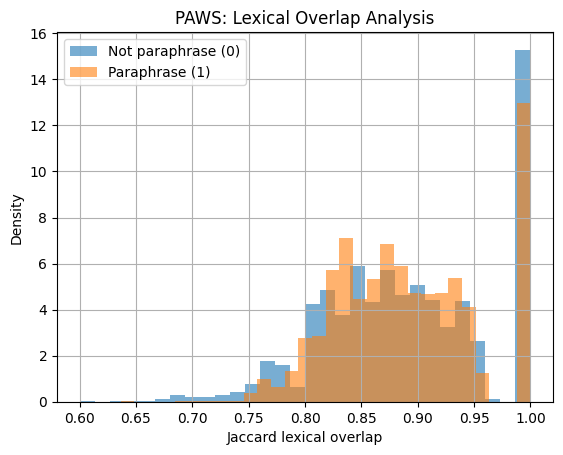

Average overlap score (label 0): 0.8905422585699789
Average overlap score (label 1): 0.8903039568751945


In [ ]:
# 15. b)

word_regex = re.compile(r"[a-z]+")

def get_words(text):
    return set(word_regex.findall(text.lower()))

def jaccard_similarity(words1, words2):
    intersection = words1 & words2
    union = words1 | words2
    return len(intersection) / len(union) if union else 0.0

test_data = ds["test"]

overlap_non_para = []
overlap_para = []

for s1, s2, label in zip(
    test_data["sentence1"],
    test_data["sentence2"],
    test_data["label"]
):
    words1 = get_words(s1)
    words2 = get_words(s2)
    score = jaccard_similarity(words1, words2)

    if label == 0:
        overlap_non_para.append(score)
    else:
        overlap_para.append(score)

plt.figure()
plt.hist(overlap_non_para, bins=30, alpha=0.6, label="Non paraphrase", density=True)
plt.hist(overlap_para, bins=30, alpha=0.6, label="Paraphrase", density=True)
plt.xlabel("Jaccard lexical overlap")
plt.ylabel("Density")
plt.title("PAWS: Lexical Overlap Analysis")
plt.legend()
plt.grid(True)
plt.show()

print("Average overlap score (label 0):", np.mean(overlap_non_para))
print("Average overlap score (label 1):", np.mean(overlap_para))

Why might bag-of-words features struggle on this dataset?

    Bag-of-words models struggle because paraphrase and non-paraphrase pairs share very similar vocabularies and have high overlap. So it struggles to distinguish meaning.

In [ ]:
# 15. c)

## BASED ON QUESTION 11 ##